# Dataset Creation and Cleansing


### Data Preprocessing Pipeline

The data preprocessing pipeline consists of several key stages to prepare the dataset for modeling:

1. **Data Loading**: The `load_data` function in `data_loading.py` loads multiple CSV files and merges them into a single DataFrame using the 'id' column as the merging key.

2. **Missing Value Imputation**: The `infer_missing_values_in_dataframe` function in `llm_dataset_filler.py` uses a local LLM to infer missing values for specific fields (e.g., Age, Gender, Education Level) based on the provided descriptions. It utilizes asynchronous calls to the LLM API and updates the DataFrame with inferred values.

3. **Feature Engineering**: The `feature_engineering.py` file contains functions that split the data into training and testing sets (`split_data`), preprocess the training data by encoding categorical variables, target encoding 'Job Title', normalizing numerical variables (`normalize_train_data`), and preprocess the test data using the fitted encoders and scaler (`normalize_test_data`). in this step we also drop unnecesary features such as gender and id.

In [6]:
#necesary imports

import matplotlib.font_manager as fm
import logging
import pickle
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from tensorflow import keras
import joblib
fm._log.setLevel(logging.WARNING)
from src import data_loading
from src import preprocessing
from src import visualize_data
from src import feature_engenieering
from src import modeling
from src import evaluation
from src import model_compare

DEBUG:src.llm_dataset_filler:Total rows with missing values: 14



Full Merged Dataset:
   id   Age  Gender Education Level          Job Title  Years of Experience  \
0   0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1   1  28.0  Female        Master's       Data Analyst                  3.0   
2   2  45.0    Male             PhD     Senior Manager                 15.0   
3   3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4   4  52.0    Male        Master's           Director                 20.0   

                                         Description    Salary  
0  I am a 32-year-old male working as a Software ...   90000.0  
1  I am a 28-year-old data analyst with a Master'...   65000.0  
2  I am a 45-year-old Senior Manager with a PhD a...  150000.0  
3  I am a 36-year-old female Sales Associate with...   60000.0  
4  I am a 52-year-old male with over two decades ...  200000.0  
      id   Age  Gender Education Level                      Job Title  \
370  370  35.0  Female      Bachelor's  

DEBUG:src.llm_dataset_filler:Index 332: Received NDJSON response for Job Title.
DEBUG:src.llm_dataset_filler:Index 260: Received NDJSON response for Gender.
DEBUG:src.llm_dataset_filler:Index 221: Received NDJSON response for Age.
DEBUG:src.llm_dataset_filler:Index 235: Received NDJSON response for Gender.
DEBUG:src.llm_dataset_filler:Index 260: Inferred Gender: Not found
DEBUG:src.llm_dataset_filler:Index 332: Inferred Job Title: Senior UX Designer
DEBUG:src.llm_dataset_filler:Index 221: Inferred Age: 31
DEBUG:src.llm_dataset_filler:Index 235: Inferred Gender: Male
DEBUG:src.llm_dataset_filler:Index 172: Received NDJSON response for Job Title.
DEBUG:src.llm_dataset_filler:Index 260: Received NDJSON response for Education Level.
DEBUG:src.llm_dataset_filler:Index 260: Received NDJSON response for Job Title.
DEBUG:src.llm_dataset_filler:Index 139: Received NDJSON response for Education Level.
DEBUG:src.llm_dataset_filler:Index 172: Inferred Job Title: Not found
DEBUG:src.llm_dataset_fil


Missing Values in Full Dataset:
id                     0
Age                    3
Gender                 3
Education Level        2
Job Title              2
Years of Experience    2
Description            3
Salary                 2
dtype: int64

Rows with Missing Values:
      id   Age Gender Education Level                    Job Title  \
111  111  37.0   Male      Bachelor's     Software Project Manager   
125  125  26.0   Male      Bachelor's            Junior Accountant   
172  172   NaN    NaN             NaN                          NaN   
177  177  31.0   Male      Bachelor's            Junior Accountant   
219  219  40.0    NaN      Bachelor's  Senior Sales Representative   
260  260   NaN    NaN             NaN                          NaN   
315  315   NaN   Male      Bachelor's     Senior Software Engineer   

     Years of Experience                                        Description  \
111                  9.0                                                NaN   
125     

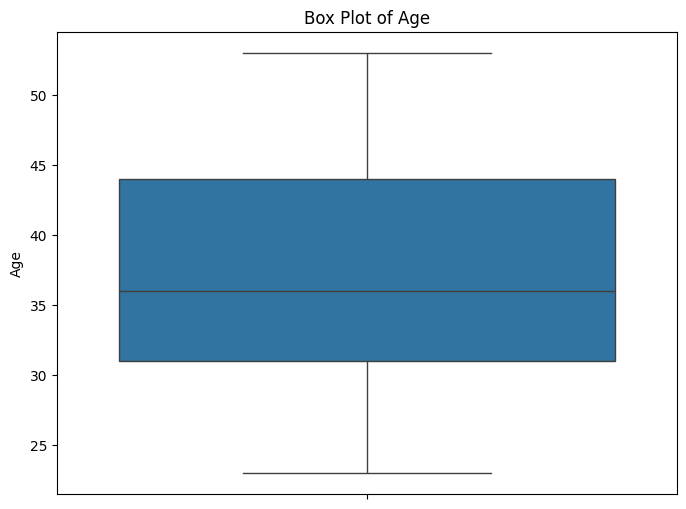

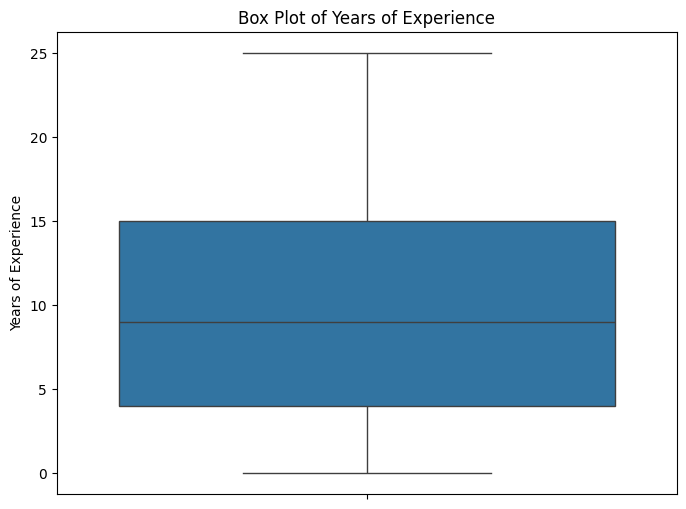

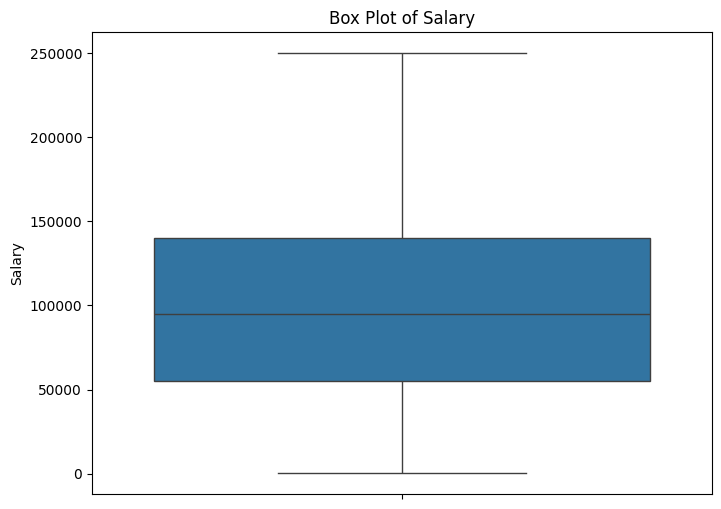

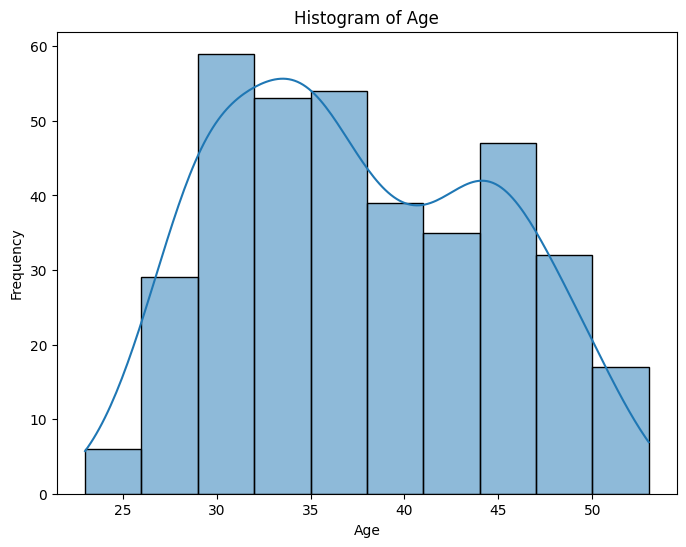

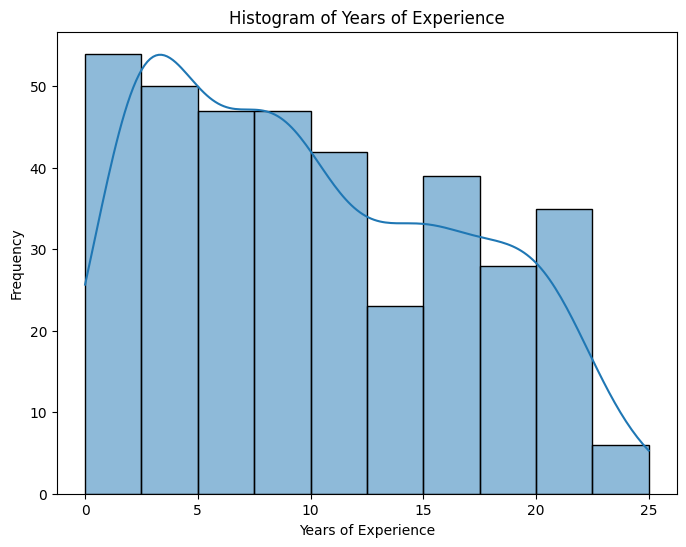

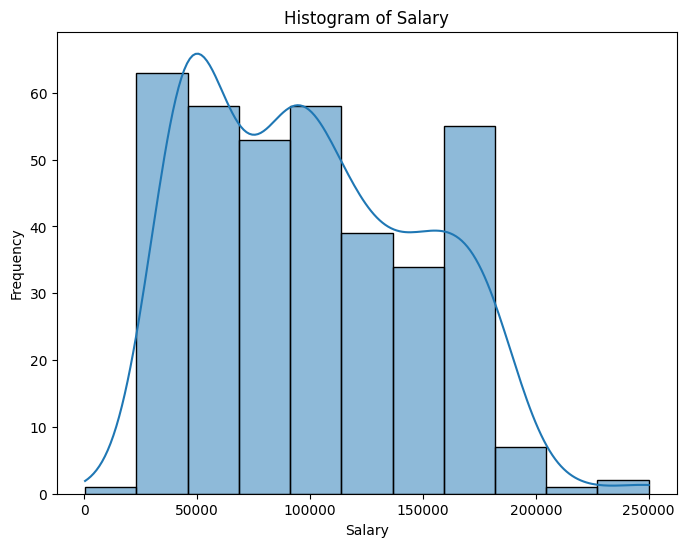

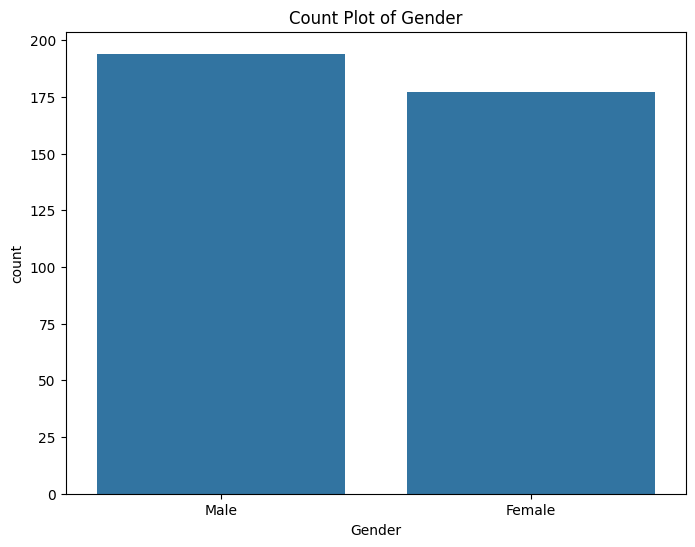

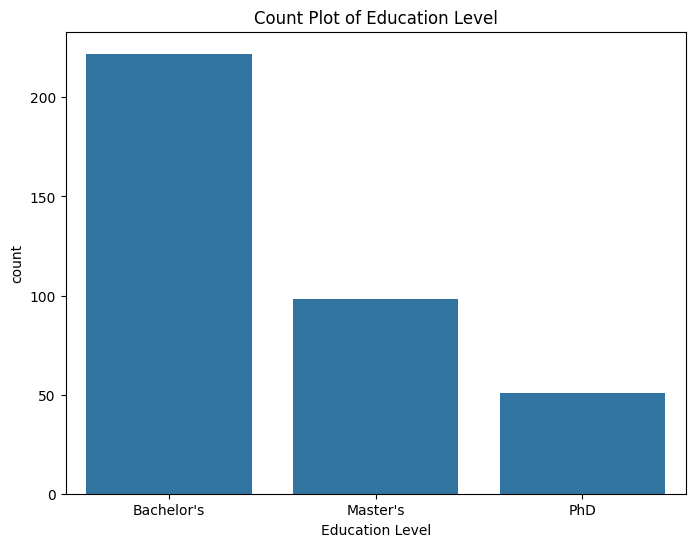

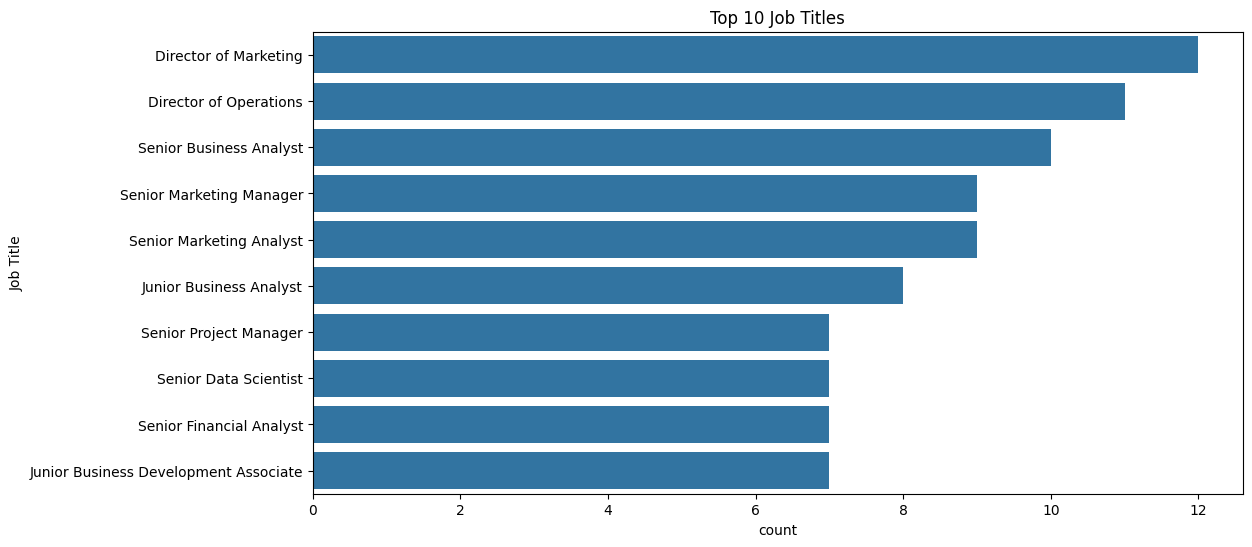

Scaler saved to ./models/scaler.pkl
Target encoder saved to ./models/target_encoder.pkl
Job title mapping saved to ./models/job_title_mapping.pkl
Scaler saved to ./models/nn_scaler.pkl
Target encoder saved to ./models/nn_target_encoder.pkl
Job title mapping saved to ./models/nn_job_title_mapping.pkl


In [10]:

#files path for the raw dataset:

data_files = ['./data/people.csv','./data/descriptions.csv','./data/salary.csv',]


#merge datasets in a cohesive Dataframe

full_dataset = data_loading.load_data(data_files)


#preprocessing of the dataframe adds missing values with LLM inference over descriptions of each row, drops the incomplete rows and cleans up the data.

cleansed_dataset = await preprocessing.preprocess(full_dataset)

visualize_data.visualize_dataset(cleansed_dataset)


#split the dataset into an 80 / 20 ratio for training and testing.

X_train, X_test, y_train, y_test = feature_engenieering.split_data(cleansed_dataset)


#normalize and scale the datasets using MinMaxScaler and target encoder for random forest

normalized_X_train, te, scaler = feature_engenieering.normalize_train_data(X_train, y_train,MinMaxScaler())

normalized_X_test = feature_engenieering.normalize_test_data(X_test, te, scaler)


#normalize and scale the datasets using MinMaxScaler and target encoder for Neural Networks

normalized_X_train_nn, te_nn, scaler_nn = feature_engenieering.normalize_train_data(X_train, y_train,StandardScaler(),"nn_")

normalized_X_test_nn = feature_engenieering.normalize_test_data(X_test, te_nn, scaler_nn)

X_train.to_pickle("./data/X_train.pkl")
y_train.to_pickle("./data/y_train.pkl")
X_test.to_pickle("./data/X_test.pkl")
y_test.to_pickle("./data/y_test.pkl")
normalized_X_train.to_pickle("./data/normalized_X_train.pkl")
normalized_X_train_nn.to_pickle("./data/normalized_X_train_nn.pkl")
normalized_X_test.to_pickle("./data/normalized_X_test.pkl")
normalized_X_test_nn.to_pickle("./data/normalized_X_test_nn.pkl")


### Dummy Regressor Baseline model training

In [11]:
#Load generated datasets as pkl

normalized_X_train = pd.read_pickle('./data/normalized_X_train.pkl')
normalized_X_train_nn = pd.read_pickle('./data/normalized_X_train_nn.pkl')

normalized_X_test = pd.read_pickle('./data/normalized_X_test.pkl')
normalized_X_test_nn = pd.read_pickle('./data/normalized_X_test_nn.pkl')

y_train = pd.read_pickle('./data/y_train.pkl')
y_test = pd.read_pickle('./data/y_test.pkl')

With the datasets created we use the train with MinMaxScaling dataset splits in a script to create a Random Forest Regressor using the scikit-learn framework.

We traing a Dummy Reggressor to use as a baseline for model performance comparison and then train a Random Forest Regressor algorithm with hyperparameter tuning. We also evaluate the trained model by calculating metrics such as mean absolute error (MAE), root mean squared error (RMSE) and R-squared e (R2) and plot a scatterplot of predicted vs actual salaries.

In [ ]:

dummy = modeling.train_dummy_regressor(normalized_X_train, y_train)

### Random Forest Regressor training and evaluation

In [ ]:
#train a model using a random forest regressor algorithm and print out the predictions for the normalized test data.

rf_model = modeling.train_model(normalized_X_train, y_train)


In [ ]:
#use the test dataset to predict salaries based on the trained model for a first fast evaluation.


evaluation.evaluate_model(normalized_X_test, y_test, normalized_X_train,y_train, rf_model)

Next we use Confidence intervals to further test the  models performance using bootstraping 

In [14]:

evaluation.calculate_metrics(normalized_X_test, y_test, rf_model)

AttributeError: 'numpy.ndarray' object has no attribute 'predict'

### Random Forest feature selection process.



I choose the Random Forest Reggresor to be able to catch non linear relationships better with realtively low data quantity for training, the model is Hyperparametrized using a grid approach and the best model is selected for testing.

In the process of selecting features for the Random Forest Regressor model, based on correlation and feature importance analysis after the first "naive" model was trained in the normalized data as is to gather more information on the relationships and model error R-squared Score (R²).

it is also quite notable that the heteroscedasticity present in the middle of the distribution seems to be caused by the dataset itself, most possibly by the lack of examples to fill the distribution appropiately, otherwise the distribution of residuals seems to be acceptable considering there are no statiscally significant outliers in the dataset.

        Random Forest Regressor Performance After Hyperparameter Tuning:
        Mean Squared Error (MSE): 866064920.96
        Mean Absolute Error (MAE): 17982.33
        R-squared Score (R²): 0.65
        
![img](./plots/residuals_distribution.png)
![Feature Importance](./plots/feature_importance.png)
![feature correlation heatmap](./plots/feature_correlation_heatmap.png)



It can be seen now better results by droping geneder since it has a really low correlation with salary and importance , and lower the smoothing for the encoded job titles to 3 (10 was the previous value).

        Random Forest Regressor Performance After Hyperparameter Tuning:
        Mean Squared Error (MSE): 600148032.12
        Mean Absolute Error (MAE): 14748.68
        R-squared Score (R²): 0.76

![img](./plots/residuals_distribution_2.png)
![Feature Importance](./plots/feature_importance_2.png)
![feature correlation heatmap](./plots/feature_correlation_heatmap_2.png)

        
next feature to remove, surprinsingly is education level wich has a low correlation with salary, but if pruned from the dataset the model shows performs worst than before with the same hyperparametrization.

        Random Forest Regressor Performance After Hyperparameter Tuning:
        Mean Squared Error (MSE): 808374516.33
        Mean Absolute Error (MAE): 17240.95
        R-squared Score (R²): 0.67

![img](./plots/residuals_distribution_3.png)
![Feature Importance](./plots/feature_importance_3.png)
![feature correlation heatmap](./plots/feature_correlation_heatmap_3.png)



### Neural Network training and evaluation

in this step we create a second model to test performance of different approaches in this specific problem. I'm using the same dataset and features as the random forest regressor but normalized using the stardad scaling between -1 and 1 wich provides better performances on NN sequiential models

In [ ]:
nn_model = modeling.train_NN_model(normalized_X_train_nn,y_train)

In [ ]:
#use the test dataset to predict salaries based on the trained model for a first fast evaluation.

nn_model = keras.models.load_model('./models/neural_network_model.keras')

evaluation.evaluate_NN_model(normalized_X_test_nn, y_test, nn_model)

In [ ]:
evaluation.calculate_metrics(normalized_X_test_nn, y_test, nn_model)

### Models Comparison against dummy regressor

In [ ]:
nn_model = keras.models.load_model('./models/neural_network_model.keras')
dummy = joblib.load(open('./models/dummy_reggresor_model.pkl', 'rb'))
rf_model = joblib.load(open('./models/random_forest_model.pkl', 'rb'))



models_data = {
    'Random Forest': (rf_model, normalized_X_test, y_test),
    'Neural Network': (nn_model, normalized_X_test_nn, y_test),
    'Dummy Regresson': (dummy, normalized_X_test, y_test)
}

comparison_results = model_compare.compare_models(models_data, y_test)


AttributeError: 'numpy.ndarray' object has no attribute 'predict'

### Final Model Selection

After generation both aproaches for modeling the problem i settled on using the neural network approach since it seems to capture better the relationships between the features and is in general more precise.